# Batch Normalization Experiments

### NET 1

To verify the effects of `internal covariate shift` on training, and the ability of `Batch Normalization` to combat it, we considered the problem of predicting the digit class on the MNIST dataset (LeCun et al., 1998a). We used a very simple network, with a 28x28 binary image as input, and 3 fully-connected hidden layers with 100 activations each. Each hidden layer computes y = g(W u+b) with sigmoid nonlinearity, and the weights W initialized to small random Gaussian values. The last hidden layer is followed by a fully-connected layer with 10 activations (one per class) and cross-entropy loss.

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from IPython.display import Image

In [2]:
# Hyper parameters 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10 
batch_size = 60
num_epochs = 15

In [4]:
# MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

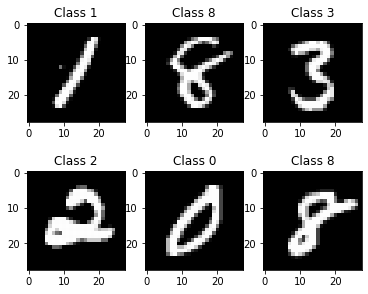

In [27]:
# Some pictures 
pictures, labels = iter(train_loader).next()

plt.figure(figsize=(6, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(pictures[i][0], cmap='gray')
    plt.title(f'Class {labels[i]}')
plt.show()

#### Network without BN

In [27]:
class DefaultNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(DefaultNet, self).__init__()
        self.h1 = nn.Linear(input_size, hidden_size)
        self.h2 = nn.Linear(hidden_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Tracking history of sigmoid() outputs
        self.sout1 = []
        self.sout2 = []
        self.sout3 = []

    def forward(self, x):
        out = self.h1(x)
        out = self.sigmoid(out)
        self.sout1.append(out)
        out = self.h2(out)
        out = self.sigmoid(out)
        self.sout2.append(out)
        out = self.h3(out)
        out = self.sigmoid(out)
        self.sout3.append(out)
        out = self.fc(out)
        return out # We don't apply softmax() here because we will use Cross Entropy below

In [28]:
# Model, criterion, optimizer
learning_rate = 0.001

model = DefaultNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # Applying softmax()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

writer = SummaryWriter('runs/without_BN')

In [29]:
total_samples = len(train_loader)
running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.reshape(-1, 28 * 28)

        # moving to GPU if possible 
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()

        # info 
        if (i+1) % 100 == 0:
            # Writing loss
            writer.add_scalar('training_loss', running_loss / 100., global_step=epoch * total_samples + i)
            # Writing accuracy
            writer.add_scalar('accuracy', running_correct / 100., global_step=epoch * total_samples + i)
            if (i+1) % 500 == 0:
                print(f'Epoch {epoch+1}/{num_epochs} | Step {i+1}/{total_samples} | Loss = {loss.item():.4f}')

            running_loss = 0
            running_correct = 0

Epoch 1/15 | Step 500/1000 | Loss = 0.4951
Epoch 1/15 | Step 1000/1000 | Loss = 0.3353
Epoch 2/15 | Step 500/1000 | Loss = 0.2126
Epoch 2/15 | Step 1000/1000 | Loss = 0.0741
Epoch 3/15 | Step 500/1000 | Loss = 0.1462
Epoch 3/15 | Step 1000/1000 | Loss = 0.2125
Epoch 4/15 | Step 500/1000 | Loss = 0.1438
Epoch 4/15 | Step 1000/1000 | Loss = 0.1452
Epoch 5/15 | Step 500/1000 | Loss = 0.1218
Epoch 5/15 | Step 1000/1000 | Loss = 0.0605
Epoch 6/15 | Step 500/1000 | Loss = 0.0327
Epoch 6/15 | Step 1000/1000 | Loss = 0.2415
Epoch 7/15 | Step 500/1000 | Loss = 0.0552
Epoch 7/15 | Step 1000/1000 | Loss = 0.0633
Epoch 8/15 | Step 500/1000 | Loss = 0.0727
Epoch 8/15 | Step 1000/1000 | Loss = 0.0922
Epoch 9/15 | Step 500/1000 | Loss = 0.0833
Epoch 9/15 | Step 1000/1000 | Loss = 0.0445
Epoch 10/15 | Step 500/1000 | Loss = 0.1559
Epoch 10/15 | Step 1000/1000 | Loss = 0.0486
Epoch 11/15 | Step 500/1000 | Loss = 0.0122
Epoch 11/15 | Step 1000/1000 | Loss = 0.0156
Epoch 12/15 | Step 500/1000 | Loss = 0.

In [30]:
# Evaluating

true_labels = []
preds = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0 

    for images, labels in test_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1) # 1 = along rows
        n_correct += (predictions == labels).sum().item()
        n_samples += labels.shape[0]
        
        predicted_probs = [F.softmax(output, dim=0) for output in outputs]

        true_labels.append(labels)
        preds.append(predicted_probs)
        
    true_labels = torch.cat(true_labels)
    preds = torch.cat([torch.stack(batch) for batch in preds])

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy = {acc}%')

Accuracy = 96.94%


In [56]:
with torch.no_grad():
    sigmoid1_outs = torch.cat(model.sout1).numpy()
    sigmoid2_outs = torch.cat(model.sout2).numpy()
    sigmoid3_outs = torch.cat(model.sout3).numpy()

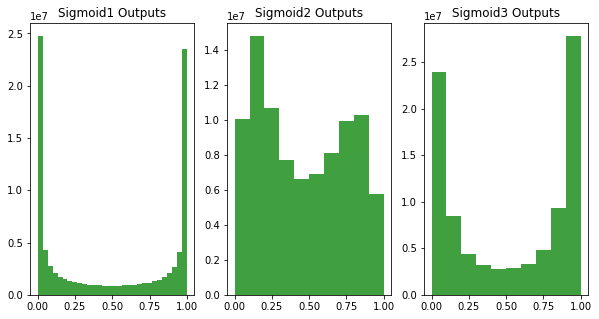

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.hist(sigmoid1_outs.ravel(), 30, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid1 Outputs')
plt.subplot(132)
plt.hist(sigmoid2_outs.ravel(), 10, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid2 Outputs')
plt.subplot(133)
plt.hist(sigmoid3_outs.ravel(), 10, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid3 Outputs')
plt.show()

In [15]:
# BN Net

class BNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(BNNet, self).__init__()
        self.h1 = nn.Linear(input_size, hidden_size)
        self.h2 = nn.Linear(hidden_size, hidden_size)
        self.h3 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # BN layers
        self.bn1 = nn.BatchNorm1d(hidden_size) # We have (batch_size, hidden_size) outs 
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        
        # Tracking history of sigmoid() outputs
        self.sout1 = []
        self.sout2 = []
        self.sout3 = []

    def forward(self, x):
        out = self.bn1(self.h1(x))
        out = self.sigmoid(out)
        self.sout1.append(out)
        out = self.bn2(self.h2(out))
        out = self.sigmoid(out)
        self.sout2.append(out)
        out = self.bn3(self.h3(out))
        out = self.sigmoid(out)
        self.sout3.append(out)
        out = self.fc(out)
        return out # We don't apply softmax() here because we will use Cross Entropy below

In [16]:
# Model, criterion, optimizer
learning_rate = 0.001

model_BN = BNNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # Applying softmax()
optimizer = torch.optim.Adam(model_BN.parameters(), lr=learning_rate)

writer = SummaryWriter('runs/with_BN')

In [17]:
total_samples = len(train_loader)
running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.reshape(-1, 28 * 28)

        # moving to GPU if possible 
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model_BN(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()

        # info 
        if (i+1) % 100 == 0:
            # Writing loss
            writer.add_scalar('training_loss', running_loss / 100., global_step=epoch * total_samples + i)
            # Writing accuracy
            writer.add_scalar('accuracy', running_correct / 100., global_step=epoch * total_samples + i)
            if (i+1) % 500 == 0:
                print(f'Epoch {epoch+1}/{num_epochs} | Step {i+1}/{total_samples} | Loss = {loss.item():.4f}')

            running_loss = 0
            running_correct = 0

Epoch 1/15 | Step 500/1000 | Loss = 0.5346
Epoch 1/15 | Step 1000/1000 | Loss = 0.2261
Epoch 2/15 | Step 500/1000 | Loss = 0.2406
Epoch 2/15 | Step 1000/1000 | Loss = 0.0928
Epoch 3/15 | Step 500/1000 | Loss = 0.1748
Epoch 3/15 | Step 1000/1000 | Loss = 0.1110
Epoch 4/15 | Step 500/1000 | Loss = 0.1161
Epoch 4/15 | Step 1000/1000 | Loss = 0.0790
Epoch 5/15 | Step 500/1000 | Loss = 0.0765
Epoch 5/15 | Step 1000/1000 | Loss = 0.0615
Epoch 6/15 | Step 500/1000 | Loss = 0.0463
Epoch 6/15 | Step 1000/1000 | Loss = 0.1032
Epoch 7/15 | Step 500/1000 | Loss = 0.1327
Epoch 7/15 | Step 1000/1000 | Loss = 0.0306
Epoch 8/15 | Step 500/1000 | Loss = 0.0459
Epoch 8/15 | Step 1000/1000 | Loss = 0.0512
Epoch 9/15 | Step 500/1000 | Loss = 0.0248
Epoch 9/15 | Step 1000/1000 | Loss = 0.0938
Epoch 10/15 | Step 500/1000 | Loss = 0.0279
Epoch 10/15 | Step 1000/1000 | Loss = 0.1001
Epoch 11/15 | Step 500/1000 | Loss = 0.0176
Epoch 11/15 | Step 1000/1000 | Loss = 0.0715
Epoch 12/15 | Step 500/1000 | Loss = 0.

In [18]:
# Addition: saving model

FILE = "model.pth"
torch.save(model_BN.state_dict(), FILE)

In [31]:
# Evaluating

true_labels_bn = []
preds_bn = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0 

    for images, labels in test_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model_BN(images)
        
        # value, index
        _, predictions = torch.max(outputs, 1) # 1 = along rows
        n_correct += (predictions == labels).sum().item()
        n_samples += labels.shape[0]
        
        predicted_probs = [F.softmax(output, dim=0) for output in outputs]

        true_labels_bn.append(labels)
        preds_bn.append(predicted_probs)
        
    true_labels_bn = torch.cat(true_labels_bn)
    preds_bn = torch.cat([torch.stack(batch) for batch in preds_bn])

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy = {acc}%')

Accuracy = 97.3%


In [73]:
with torch.no_grad():
    sigmoid1_outs = torch.cat(model_BN.sout1).numpy()
    sigmoid2_outs = torch.cat(model_BN.sout2).numpy()
    sigmoid3_outs = torch.cat(model_BN.sout3).numpy()

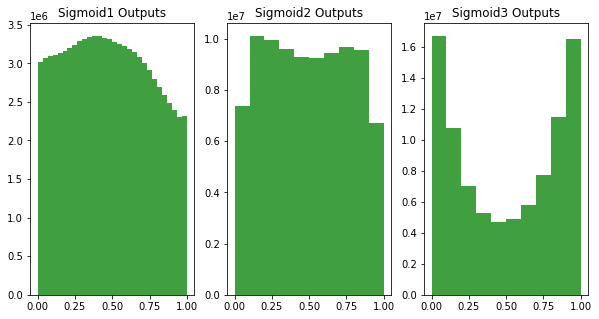

In [74]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.hist(sigmoid1_outs.ravel(), 30, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid1 Outputs')
plt.subplot(132)
plt.hist(sigmoid2_outs.ravel(), 10, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid2 Outputs')
plt.subplot(133)
plt.hist(sigmoid3_outs.ravel(), 10, range=(0, 1), facecolor='g', alpha=0.75)
plt.title('Sigmoid3 Outputs')
plt.show()

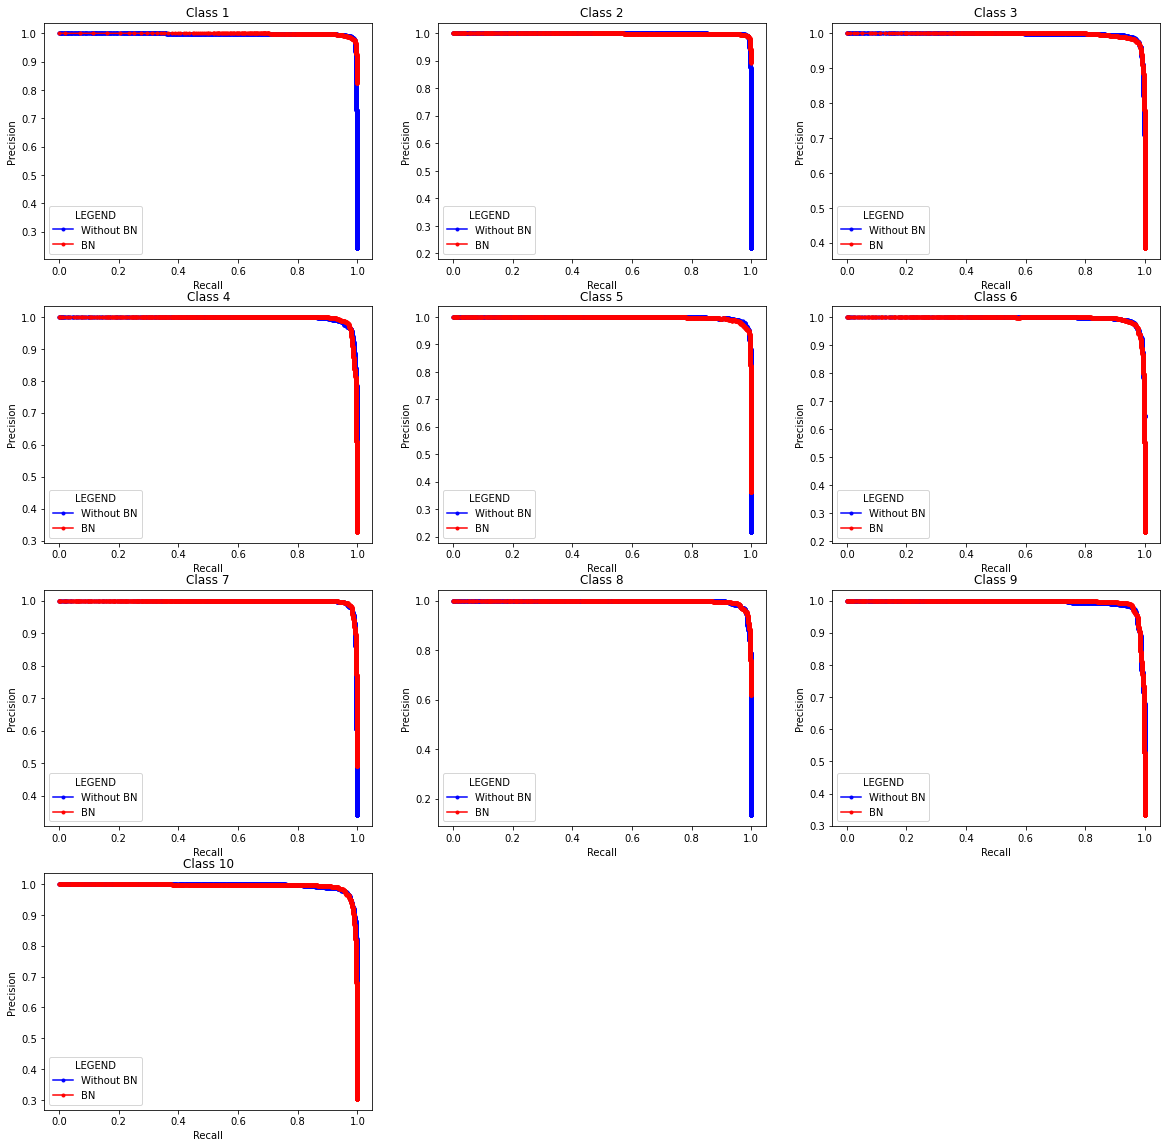

In [75]:
# PR curves

plt.figure(figsize=(20, 20))
for class_index in range(10):
    lr_precision, lr_recall, _ = precision_recall_curve(true_labels == class_index, preds[:, class_index])
    lr_precision_bn, lr_recall_bn, _ = precision_recall_curve(true_labels_bn == class_index, preds_bn[:, class_index])
    plt.subplot(4, 3, class_index+1)
    plt.plot(lr_recall, lr_precision, '.b-', label='Logistic')
    plt.plot(lr_recall_bn, lr_precision_bn, '.r-', label='Logistic')
    plt.legend(['Without BN', 'BN'], title='LEGEND')
    plt.title(f'Class {class_index+1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
plt.show()

#### Accuracy & Loss
`orange` - without BN

`blue` - with BN

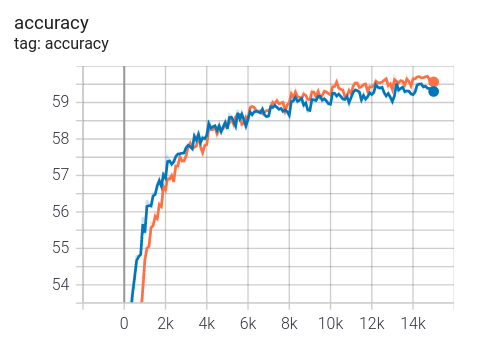

In [77]:
Image(filename='./data/acc.png')

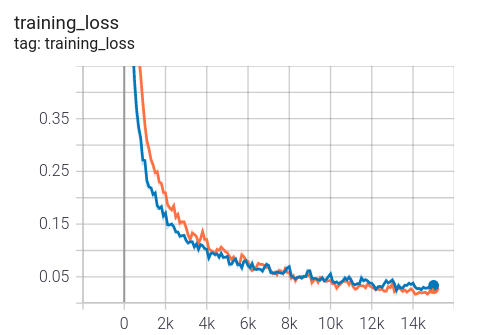

In [78]:
Image(filename='./data/loss.png')

### NET 2

Source: `https://github.com/poojamahajan0712/medium_blog/blob/master/BN/MNIST_basic.ipynb`

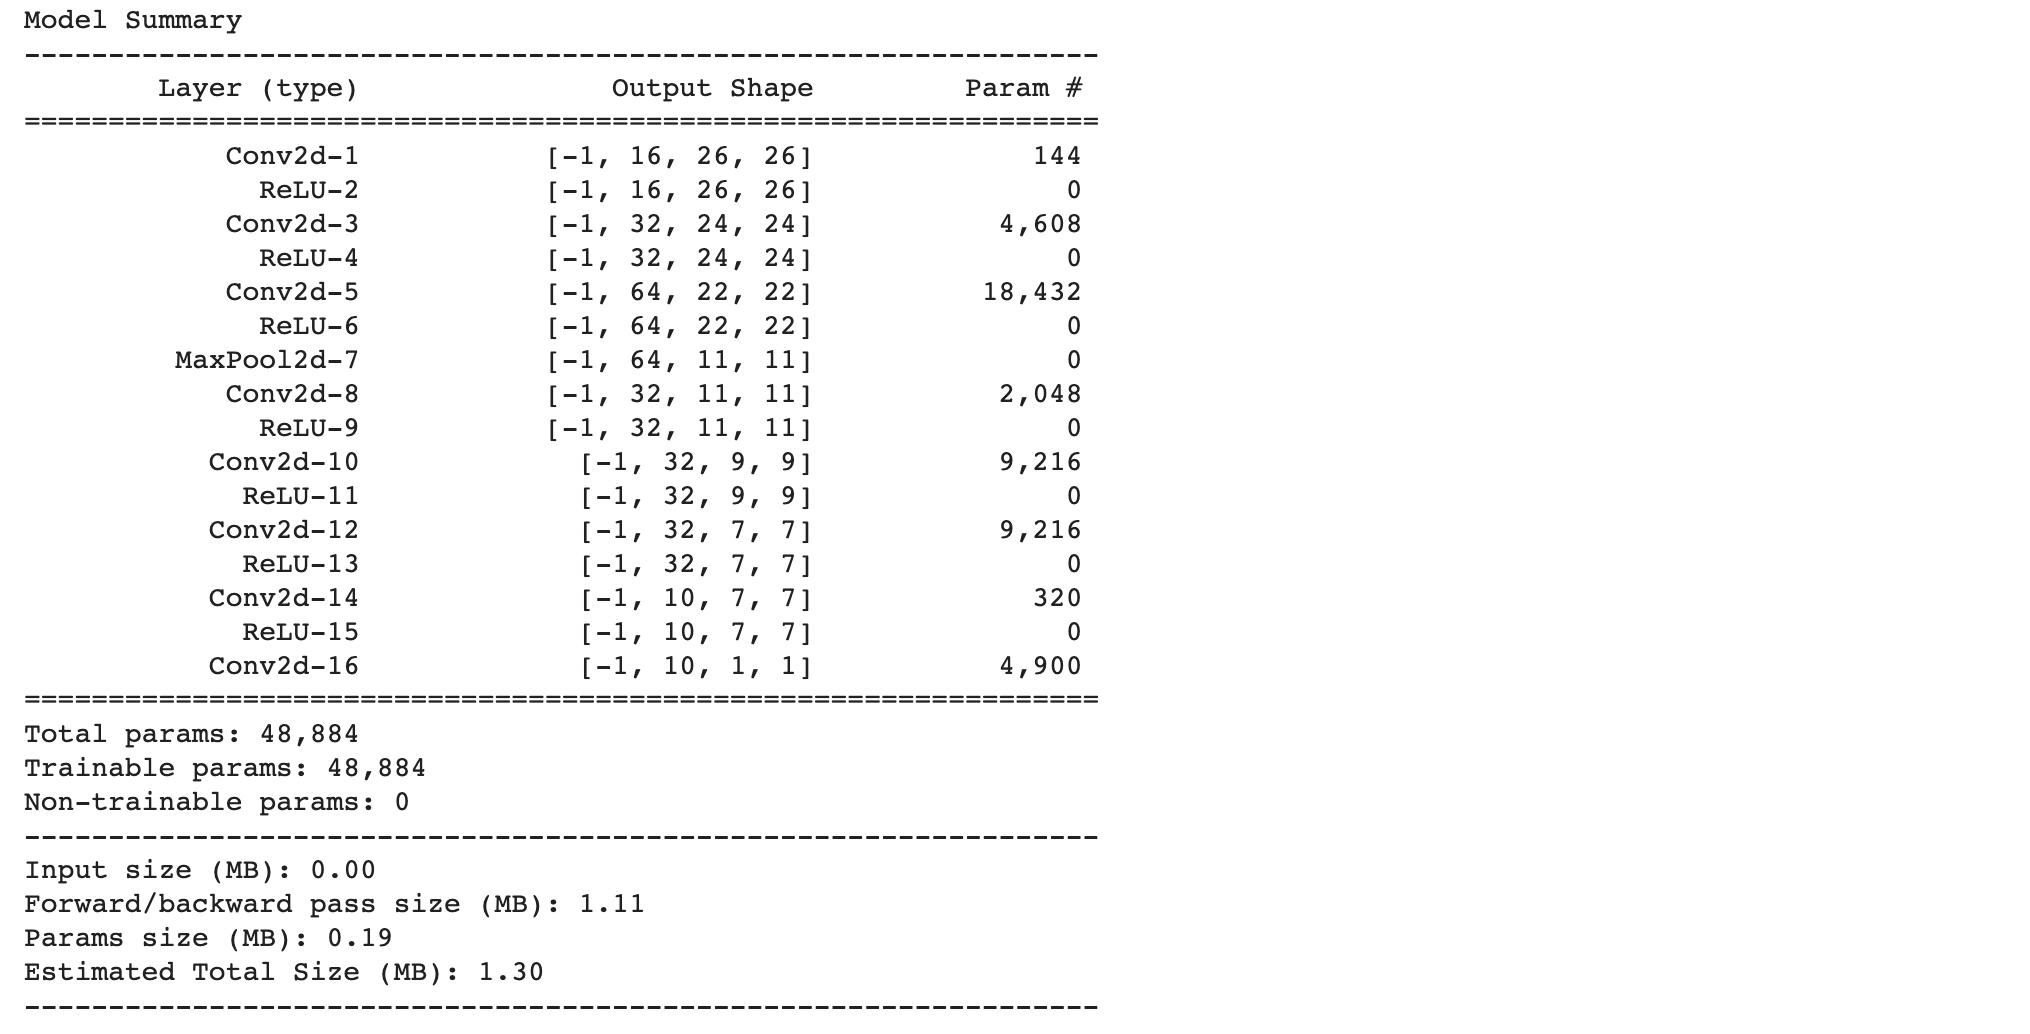

In [5]:
Image(filename='./data/cnn.png')

*CNN*

    1. Conv2D(in_channels=1, out_channels=16, kernel_size=3, stride=1, pad=0)
    2. ReLU
    3. Conv2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, pad=0)
    4. ReLU
    5. Conv2D(in_channels=32, out_channels=64, kernel_size=3, stride=1, pad=0)
    6. ReLU
    7. MaxPool2D(kernel_size=2, stride=2)
    8. Conv2D(in_channels=64, out_channels=32, kernel_size=3, stride=1, pad=1)
    9. ReLU
    10. Conv2D(in_channels=32, out_channels=32, kernel_size=3, stride=1, pad=0)
    11. ReLU
    12. Conv2D(in_channels=32, out_channels=32, kernel_size=3, stride=1, pad=0)
    13. ReLU
    14. Conv2D(in_channels=32, out_channels=10, kernel_size=3, stride=1, pad=1)
    15. ReLU
    16. Conv2D(in_channels=10, out_channels=10, kernel_size=7, stride=1, pad=0)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [4]:
# 2. Loading and transforming dataset 
#Transformations
#Transforms are common image transformations. They can be chained together using Compose
trans = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))        
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=trans)
test = datasets.MNIST('./data', train=False, download=True, transform=trans)

SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#you have to use data loader in PyTorch that will actually read the data within batch size and put into memory
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


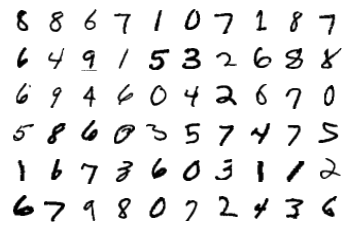

In [5]:
#3 View few images from train data 
# loading one set of train data batch 

dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r') # gray_r switches black and white!
    # squeeze removes axes of length one from numpy array (similar to reshape(..) or view(..))

### Without BN 

In [6]:
#4 Building network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#5 Model Summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Model Summary")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           2,048
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 32, 9, 9]           9,216
             ReLU-11             [-1, 32, 9, 9]               0
           Conv2d-12             [-1, 32, 7, 7]           9,216
             ReLU-13             [-1, 32, 7, 7]               0
           Conv2d-14 

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10

In [11]:
writer = SummaryWriter('runs/without_BN')

total_samples = len(train_loader)

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # moving to GPU if possible 
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()

        # info 
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} | Step {i+1}/{total_samples} | Loss = {loss.item():.4f}')
            writer.add_scalar('training_loss', running_loss / 100., global_step=epoch * total_samples + i)
            writer.add_scalar('accuracy', running_correct / 100., global_step=epoch * total_samples + i)

            running_loss = 0
            running_correct = 0

Epoch 1/10 | Step 100/938 | Loss = 2.3020
Epoch 1/10 | Step 200/938 | Loss = 2.3017
Epoch 1/10 | Step 300/938 | Loss = 2.2450
Epoch 1/10 | Step 400/938 | Loss = 2.3022
Epoch 1/10 | Step 500/938 | Loss = 2.3011
Epoch 1/10 | Step 600/938 | Loss = 2.2278
Epoch 1/10 | Step 700/938 | Loss = 0.6611
Epoch 1/10 | Step 800/938 | Loss = 0.2572
Epoch 1/10 | Step 900/938 | Loss = 0.2246
Epoch 2/10 | Step 100/938 | Loss = 0.0989
Epoch 2/10 | Step 200/938 | Loss = 0.0979
Epoch 2/10 | Step 300/938 | Loss = 0.0243
Epoch 2/10 | Step 400/938 | Loss = 0.1679
Epoch 2/10 | Step 500/938 | Loss = 0.0780
Epoch 2/10 | Step 600/938 | Loss = 0.0599
Epoch 2/10 | Step 700/938 | Loss = 0.0548
Epoch 2/10 | Step 800/938 | Loss = 0.0437
Epoch 2/10 | Step 900/938 | Loss = 0.0640
Epoch 3/10 | Step 100/938 | Loss = 0.1477
Epoch 3/10 | Step 200/938 | Loss = 0.0594
Epoch 3/10 | Step 300/938 | Loss = 0.0674
Epoch 3/10 | Step 400/938 | Loss = 0.0589
Epoch 3/10 | Step 500/938 | Loss = 0.0477
Epoch 3/10 | Step 600/938 | Loss =

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0 

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1) # 1 = along rows
        n_correct += (predictions == labels).sum().item()
        n_samples += labels.shape[0]

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy = {acc}%')

Accuracy = 98.94%


In [14]:
FILE = 'without_BN.pth'
torch.save(model.state_dict(), FILE)

### With BN 

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26  RF 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # output_size = 22 RF 7 Jout - 1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11  RF 8 Jout - 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 11  RF 8 Jout- 2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 9  RF - 12 ,Jout - 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7 RF - 16  Jout - 2

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7  RF - 16  Jout - 2 


        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            #nn.BatchNorm2d(10),NEVER!
            # nn.ReLU() NEVER!
        ) # output_size = 1  RF -28  Jout - 2 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [20]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("Model Summary")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
Model Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,608
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 22, 22]          18,432
       BatchNorm2d-8           [-1, 64, 22, 22]             128
              ReLU-9           [-1, 64, 22, 22]               0
        MaxPool2d-10           [-1, 64, 11, 11]               0
           Conv2d-11           [-1, 32, 11, 11]           2,048
      BatchNorm2d-12           [-1, 32, 11, 11]              64
             ReLU-13           [-1, 32, 11, 11]               0
           Conv2d-14 

In [21]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10

In [22]:
writer = SummaryWriter('runs/with_BN')

total_samples = len(train_loader)

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    
    pbar = tqdm(train_loader)
    pbar_correct, pbar_processed = 0, 0
    
    print(f'Epoch {epoch}:')
    
    for i, (images, labels) in enumerate(pbar):

        # moving to GPU if possible 
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()
        
        pbar_correct += (predicted == labels).sum().item()
        pbar_processed += len(images)

        # writing scalars 
        if (i+1) % 100 == 0:
            # print(f'Epoch {epoch+1}/{num_epochs} | Step {i+1}/{total_samples} | Loss = {loss.item():.4f}')
            writer.add_scalar('training_loss', running_loss / 100., global_step=epoch * total_samples + i)
            writer.add_scalar('accuracy', running_correct / 100., global_step=epoch * total_samples + i)
            running_loss = 0
            running_correct = 0
            
        # pbar info
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={100*pbar_correct/pbar_processed:0.2f}')

Loss=2.143911838531494 Batch_id=2 Accuracy=19.79:   0%| | 2/938 [00:00<01:01, 15

Epoch 0:


Loss=0.024699602276086807 Batch_id=937 Accuracy=96.84: 100%|█| 938/938 [01:05<00
Loss=0.016040539368987083 Batch_id=1 Accuracy=100.00:   0%| | 2/938 [00:00<01:17

Epoch 1:


Loss=0.1818184107542038 Batch_id=937 Accuracy=98.86: 100%|█| 938/938 [01:12<00:0
Loss=0.0011001704260706902 Batch_id=1 Accuracy=99.22:   0%| | 2/938 [00:00<01:06

Epoch 2:


Loss=0.0009454799583181739 Batch_id=937 Accuracy=99.19: 100%|█| 938/938 [01:10<0
Loss=0.016393626108765602 Batch_id=1 Accuracy=100.00:   0%| | 1/938 [00:00<01:35

Epoch 3:


Loss=0.0015248041599988937 Batch_id=937 Accuracy=99.34: 100%|█| 938/938 [01:09<0
Loss=0.04290327429771423 Batch_id=1 Accuracy=99.22:   0%| | 2/938 [00:00<01:09, 

Epoch 4:


Loss=0.00026622862787917256 Batch_id=937 Accuracy=99.47: 100%|█| 938/938 [01:11<
Loss=0.0006122443010099232 Batch_id=1 Accuracy=100.00:   0%| | 2/938 [00:00<01:0

Epoch 5:


Loss=0.0035610939376056194 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [01:17<0
Loss=0.011784474365413189 Batch_id=1 Accuracy=100.00:   0%| | 2/938 [00:00<01:14

Epoch 6:


Loss=0.0010281512513756752 Batch_id=937 Accuracy=99.62: 100%|█| 938/938 [01:27<0
Loss=0.016590500250458717 Batch_id=2 Accuracy=98.96:   0%| | 2/938 [00:00<01:00,

Epoch 7:


Loss=0.022749071940779686 Batch_id=937 Accuracy=99.70: 100%|█| 938/938 [01:23<00
Loss=0.0018381664995104074 Batch_id=0 Accuracy=100.00:   0%| | 1/938 [00:00<01:4

Epoch 8:


Loss=0.012761460617184639 Batch_id=937 Accuracy=99.80: 100%|█| 938/938 [01:27<00
Loss=0.004356852732598782 Batch_id=1 Accuracy=100.00:   0%| | 2/938 [00:00<01:03

Epoch 9:


Loss=0.0014682830078527331 Batch_id=937 Accuracy=99.82: 100%|█| 938/938 [01:30<0


In [47]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0 

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # value, index
        _, predictions = torch.max(outputs, 1) # 1 = along rows
        n_correct += (predictions == labels).sum().item()
        n_samples += labels.shape[0]

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy = {acc}%')

Accuracy = 99.18%


In [48]:
FILE = 'with_BN.pth'
torch.save(model.state_dict(), FILE)